In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
os.getcwd()


'/home/dazai/Documents/Process mining/ProcessMining'

# Define paths, joining traing test and drop unnecessary columns 

In [14]:
path = r"/home/dazai/Documents/Process mining/Data/printer data/"
df_train = pd.read_csv(f'{path}/event-log-training.csv')
df_test = pd.read_csv(f'{path}/event-log-test.csv')


df_data = pd.concat([df_train, df_test])
df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True)
print(type(df_data['event time:timestamp'].iloc[0]))
df_data.sort_values(by=['event time:timestamp'])
df_data.reset_index(inplace=True, drop=True)

# only one value for entire column
print(df_data['case description'].unique())
print(df_data['event org:resource'].unique())
df_data.drop(['case description', 'event org:resource'], axis=1, inplace=True)

# remove whitespace at beginning and end of column name
df_data.columns = df_data.columns.str.strip()


df_data


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
['Simulated process instance']
['PRN1']


,eventID,case concept:name,case Class,event concept:name,event lifecycle:transition,event time:timestamp
0,0,1,Print,Job,start,1970-01-01 01:00:00
1,1,1,Print,Remote Print,complete,1970-01-01 01:15:00
2,2,1,Print,Read Print Options,complete,1970-01-01 01:26:00
3,3,1,Print,Rasterization,start,1970-01-01 01:38:00
4,4,1,Print,Interpretation,start,1970-01-01 01:51:00
...,...,...,...,...,...,...
40990,412316860519,96,Print,Heated Roller Spin Stop,complete,1970-12-26 15:42:00
40991,412316860520,96,Print,Fusing,complete,1970-12-26 16:01:00
40992,412316860521,96,Print,Wipe Toner on Drum,complete,1970-12-26 16:26:00
40993,412316860522,96,Print,Erase Charge on Drum,complete,1970-12-26 16:50:00


In [3]:
df_data.columns

Index(['eventID', 'case concept:name', 'case Class', 'event concept:name',
       'event lifecycle:transition', 'event time:timestamp'],
      dtype='object')

# splitting the data using self defined ratios

In [ ]:
def split(df_data, percent):
    """input percentage of testing data to split"""
    index = round(df_data.shape[0]*(percent/100))
    
    testset = df_data.iloc[-index:]
    testset.reset_index(drop=True, inplace=True)
    return df_data.iloc[:-index], testset


In [ ]:
split(df_data, 30)[0]

,eventID,case concept:name,case Class,event concept:name,event lifecycle:transition,event time:timestamp
0,0,1,Print,Job,start,01-01-1970 01:00:00.000
1,1,1,Print,Remote Print,complete,01-01-1970 01:15:00.000
2,2,1,Print,Read Print Options,complete,01-01-1970 01:26:00.000
3,3,1,Print,Rasterization,start,01-01-1970 01:38:00.000
4,4,1,Print,Interpretation,start,01-01-1970 01:51:00.000
...,...,...,...,...,...,...
28692,240518168821,6,Print,Image Creation,complete,15-10-1970 06:22:00.000
28693,240518168822,6,Print,Writing,complete,15-10-1970 06:29:00.000
28694,240518168823,6,Print,Drum Spin Start,complete,15-10-1970 06:46:00.000
28695,240518168824,6,Print,Coat Toner on Drum,complete,15-10-1970 06:54:00.000


In [ ]:
split(df_data, 30)[1]

,eventID,case concept:name,case Class,event concept:name,event lifecycle:transition,event time:timestamp
0,240518168826,6,Print,Drum Spin Start,complete,15-10-1970 07:27:00.000
1,240518168827,6,Print,Paper Roller Spin Start,complete,15-10-1970 07:36:00.000
2,240518168828,6,Print,Transfer Toner (drum to paper),complete,15-10-1970 07:42:00.000
3,240518168829,6,Print,Paper Roller Spin Stop,complete,15-10-1970 08:01:00.000
4,240518168830,6,Print,Drum Spin Stop,complete,15-10-1970 08:18:00.000
...,...,...,...,...,...,...
12293,412316860519,96,Print,Heated Roller Spin Stop,complete,26-12-1970 15:42:00.000
12294,412316860520,96,Print,Fusing,complete,26-12-1970 16:01:00.000
12295,412316860521,96,Print,Wipe Toner on Drum,complete,26-12-1970 16:26:00.000
12296,412316860522,96,Print,Erase Charge on Drum,complete,26-12-1970 16:50:00.000


## Frequency of all events

In [ ]:
events = df_train['event concept:name'].value_counts()
events.to_frame()

,event concept:name
Drum Spin Start,3478
Drum Spin Stop,3478
Fusing,2410
Coat Toner on Drum,1444
Apply Heat,1205
...,...
Document Image Ready,36
Transfer Image,36
Copy/Scan,36
Send FTP,24


<AxesSubplot:>

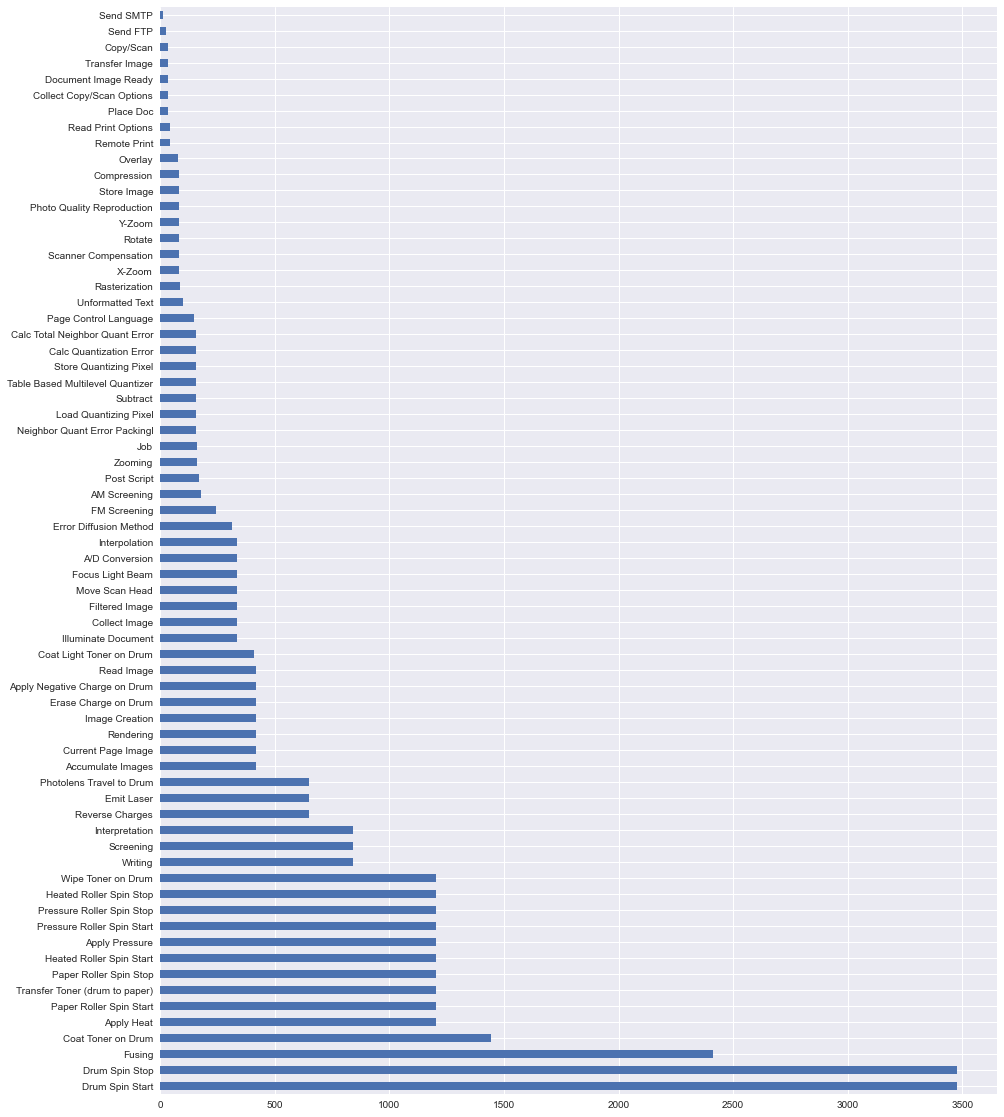

In [ ]:
fig, ax = plt.subplots()

events = df_train['event concept:name'].value_counts()
events.plot.barh(figsize=(15,20))

# calculate event time

In [4]:
df_data['case concept:name'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80, 100,   9,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99])

In [16]:
case = df_data[df_data['case concept:name']==1]
unique_events = case['event concept:name'].unique().tolist()

start = [i for i in unique_events if 'Start' in i]
stop = [i for i in unique_events if 'Stop' in i]

events = start + stop

events = [ele for ele in unique_events if ele not in events]


In [20]:
for i in events:
    display(case[case['event concept:name']== i])
    display(case[case['event concept:name']== i].shift(-1))
    print(case[case['event concept:name']== i]['event time:timestamp'])
    case['Time_diff'] = (case['event time:timestamp'] - case['event time:timestamp'].shift(1))

    break

,eventID,case concept:name,case Class,event concept:name,event lifecycle:transition,event time:timestamp,Time_diff,diff
0,0,1,Print,Job,start,1970-01-01 01:00:00,NaT,NaT
855,777,1,Print,Job,complete,1970-01-07 14:09:00,0 days 00:06:00,0 days 00:06:00


,eventID,case concept:name,case Class,event concept:name,event lifecycle:transition,event time:timestamp,Time_diff,diff
0,777.0,1.0,Print,Job,complete,1970-01-07 14:09:00,0 days 00:06:00,0 days 00:06:00
855,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT


0     1970-01-01 01:00:00
855   1970-01-07 14:09:00
Name: event time:timestamp, dtype: datetime64[ns]


/tmp/ipykernel_36405/1986840731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['Time_diff'] = (case['event time:timestamp'] - case['event time:timestamp'].shift(1))


In [22]:
case['event concept:name'].value_counts().to_frame()


,event concept:name
Drum Spin Stop,77
Drum Spin Start,77
Fusing,70
Paper Roller Spin Stop,35
Coat Toner on Drum,35
Pressure Roller Spin Start,35
Apply Pressure,35
Apply Heat,35
Pressure Roller Spin Stop,35
Paper Roller Spin Start,35


In [6]:
# df_data.set_index(["case concept:name", "eventID"], inplace=True)
# #df_data['seconds'] = [time.mktime(t.timetuple()) for t in df_data['event time:timestamp']]
# df_data["Completion Time"] = 0
# df_data.replace(0,np.NaN, inplace=True)


# def EventTime(data):
#     memory = {}
#     # print(data.columns)
#     for i, j in data[["event concept:name"]].iterrows():
#         if j[0] not in memory.keys() and data.loc[i]["event lifecycle:transition"] == "start":
#             memory[j[0]] = i
            
#         elif j[0] in memory.keys():
#             #Calculate time
#             #print(memory[j[0]],",", i)
#             time = pd.to_datetime(data.loc[i]["event time:timestamp"], dayfirst=True) - pd.to_datetime(data.loc[memory[j[0]]]["event time:timestamp"], dayfirst=True)           # print(time)
#             data.loc[i,"Completion Time"] = time

#             del memory[j[0]]
#     return data


# for idx, new_df in df_data.groupby(level=0):
#     #print(idx)
#     EventTime(new_df)
#     df_data.loc[idx] = EventTime(new_df)
    
# df_data.head(100)